https://jovian.ai/aakanksha-ns/road-signs-bounding-box-prediction

In [26]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

In [27]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

## Loading the data



In [29]:
images_path = Path('./images')
anno_path = Path('./annotations')

In [30]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [31]:
df_train = generate_train_df(anno_path)

##     Label encode the class column

In [32]:
#label encode target
class_dict = {'info': 0}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])



In [33]:
df_train.shape

(406, 8)

In [34]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images\img1.png,480,640,0,3,88,397,461
1,images\img10.png,480,640,0,135,99,480,413
2,images\img100.png,480,640,0,97,160,441,447
3,images\img101.png,480,640,0,3,165,268,434
4,images\img102.png,480,640,0,17,148,400,418


## Resizing Images and Bounding Boxes

In [35]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [36]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [37]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [38]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

C:\Users\CYBER-~1\AppData\Local\Temp/ipykernel_2128/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [39]:
df_train.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images\img1.png,480,640,0,3,88,397,461,images_resized\img1.png,"[41.0, 2.0, 215.0, 369.0]"
1,images\img10.png,480,640,0,135,99,480,413,images_resized\img10.png,"[46.0, 125.0, 193.0, 446.0]"
2,images\img100.png,480,640,0,97,160,441,447,images_resized\img100.png,"[75.0, 90.0, 209.0, 410.0]"
3,images\img101.png,480,640,0,3,165,268,434,images_resized\img101.png,"[77.0, 2.0, 203.0, 249.0]"
4,images\img102.png,480,640,0,17,148,400,418,images_resized\img102.png,"[69.0, 15.0, 195.0, 372.0]"
5,images\img103.png,480,640,0,1,79,339,460,images_resized\img103.png,"[37.0, 0.0, 215.0, 315.0]"
6,images\img104.png,480,640,0,1,33,359,433,images_resized\img104.png,"[15.0, 0.0, 202.0, 334.0]"
7,images\img105.png,480,640,0,1,191,334,560,images_resized\img105.png,"[89.0, 0.0, 262.0, 311.0]"
8,images\img106.png,480,640,0,2,195,312,566,images_resized\img106.png,"[91.0, 1.0, 265.0, 290.0]"
9,images\img107.png,480,640,0,7,108,372,483,images_resized\img107.png,"[50.0, 6.0, 226.0, 346.0]"


### Sample Image


In [40]:
im = cv2.imread(str(df_train.values[5][0]))
bb = create_bb_array(df_train.values[5])
print(im.shape)

(640, 480, 3)


In [41]:
Y = create_mask(bb, im)
mask_to_bb(Y)

C:\Users\CYBER-~1\AppData\Local\Temp/ipykernel_2128/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


array([ 79.,   1., 459., 338.], dtype=float32)

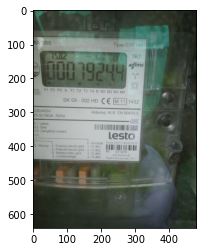

In [42]:
plt.imshow(im)

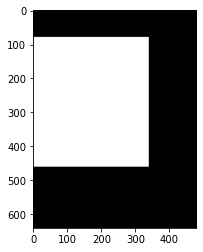

In [43]:
plt.imshow(Y, cmap='gray')

## Data augmentation

Functions in this section borrowed and modified from https://www.usfca.edu/data-institute/certificates/fundamentals-deep-learning


In [44]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [45]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [46]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

## Sample Image


In [47]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images\img1.png,480,640,0,3,88,397,461,images_resized\img1.png,"[41.0, 2.0, 215.0, 369.0]"
1,images\img10.png,480,640,0,135,99,480,413,images_resized\img10.png,"[46.0, 125.0, 193.0, 446.0]"
2,images\img100.png,480,640,0,97,160,441,447,images_resized\img100.png,"[75.0, 90.0, 209.0, 410.0]"
3,images\img101.png,480,640,0,3,165,268,434,images_resized\img101.png,"[77.0, 2.0, 203.0, 249.0]"
4,images\img102.png,480,640,0,17,148,400,418,images_resized\img102.png,"[69.0, 15.0, 195.0, 372.0]"


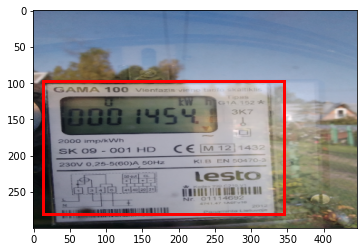

In [48]:
#original
im = cv2.imread(str(df_train.values[20][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[20][9])

In [49]:
numpy_horizontal = np.hstack((cv2.imread(str(df_train.values[20][8])),
                              cv2.imread(str(df_train.values[21][8])),
                             cv2.imread(str(df_train.values[22][8]))))

C:\Users\CYBER-~1\AppData\Local\Temp/ipykernel_2128/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


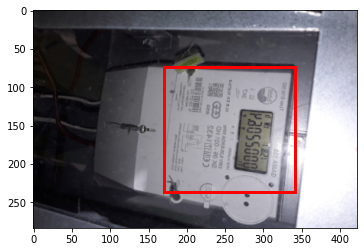

In [50]:
# after transformation
im, bb = transformsXY(str(df_train.values[155][8]),df_train.values[155][9],True )
show_corner_bb(im, bb)

## PyTorch Dataset

## Train-valid split


In [51]:
df_train = df_train.reset_index()

In [52]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Dataset

In [54]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [55]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [56]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [57]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Model

In [58]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [59]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [60]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [61]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [36]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [ ]:
torch.cuda.empty_cache() 

In [37]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=1000)

C:\Users\CYBER-~1\AppData\Local\Temp/ipykernel_6968/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


train_loss 2.898 val_loss 42180325.463 val_acc 0.000
train_loss 1.749 val_loss 14165.147 val_acc 0.000
train_loss 1.259 val_loss 163.250 val_acc 0.195
train_loss 0.780 val_loss 16.373 val_acc 0.549
train_loss 0.515 val_loss 6.966 val_acc 0.793
train_loss 0.445 val_loss 3.488 val_acc 0.866
train_loss 0.408 val_loss 1.954 val_acc 0.939
train_loss 0.376 val_loss 0.901 val_acc 0.951
train_loss 0.342 val_loss 0.376 val_acc 0.988
train_loss 0.303 val_loss 0.283 val_acc 1.000
train_loss 0.263 val_loss 0.234 val_acc 1.000
train_loss 0.217 val_loss 0.191 val_acc 1.000
train_loss 0.168 val_loss 0.157 val_acc 1.000
train_loss 0.136 val_loss 0.133 val_acc 1.000
train_loss 0.122 val_loss 0.130 val_acc 1.000
train_loss 0.112 val_loss 0.119 val_acc 1.000
train_loss 0.103 val_loss 0.115 val_acc 1.000
train_loss 0.100 val_loss 0.112 val_acc 1.000
train_loss 0.099 val_loss 0.116 val_acc 1.000
train_loss 0.100 val_loss 0.126 val_acc 1.000
train_loss 0.100 val_loss 0.127 val_acc 1.000
train_loss 0.097 val

0.01987194435464011

In [ ]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

## Prediction on Test Images

In [ ]:
!dir "saved_models/"

In [62]:
model = BB_model().cuda()
model.load_state_dict(torch.load("saved_models/size200_bs64_epoch200.pth"))
model.eval();

In [74]:
# resizing test image
im = read_image('./test_images/test1.jpg')
im = cv2.resize(im, (int(1.49*200), 200))
cv2.imwrite('./test_images_resize/test1.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [75]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./test_images_resize/test1.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

C:\Users\CYBER-~1\AppData\Local\Temp/ipykernel_2128/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [76]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 184, 274])

In [77]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 8.6994, -3.0666, -3.0637, -3.7760]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[  8.8033,   5.6301, 182.5810, 251.0139]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

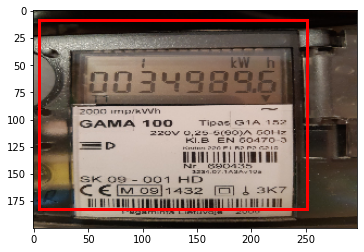

In [78]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [38]:
torch.save(model.state_dict(), "./saved_models/size200_bs64_epoch1000.pth")